Инициализация библиотек и модулей необходимых для работы, а также аутентификация в системе Google для получения доступа к диску

In [0]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Загрузка файла с текстом из Google-диск

In [0]:
downloaded = drive.CreateFile({'id':"1G1WWjsQLZwbwwe9jzyAshtE36dggjnOs"})
downloaded.GetContentFile('Work_text(1).txt')

Загрузка текста ASCII для книги в память и преобразование всех символов в нижний регистр, чтобы уменьшить словарный запас, который должна выучить сеть.

In [0]:
# load ascii text and covert to lowercase
filename = "Work_text(1).txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()

Создание набора всех отдельных символов в книге, а затем создание карты каждого символа с уникальным целым числом. Так как мы не можем моделировать символы напрямую.

In [0]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

Суммируем набор данных

In [10]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  31202
Total Vocab:  67


Разделим текст книги на подпоследовательности с фиксированной длиной в 100 символов произвольной длины.Каждый обучающий шаблон сети будет состоять из 100 временных шагов одного символа (X), за которыми следует один символьный вывод (y). 

In [11]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  31102


Нужно преобразовать тренировочные данные так, чтобы они подходили для использования с Keras. Сначала преобразуем список входных последовательностей. Далее изменить масштаб целых чисел в диапазоне от 0 до 1, чтобы облегчить изучение шаблонов сетью LSTM, которая по умолчанию использует функцию активации сигмоида. Далее произведём one-hot encoding для выходных шаблонов. 

In [0]:

X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

Инициализируем модель и определяем её архитектуру, а также визуализируем средствами keras для наглядности

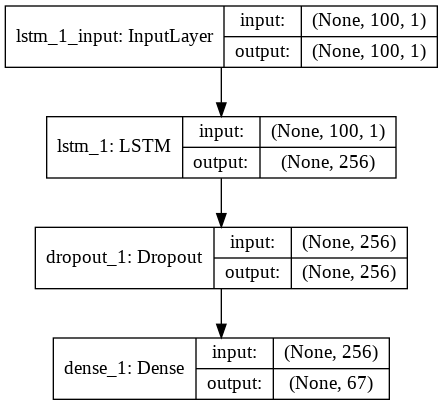

In [13]:
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Будем делать бэкап весов по каждой эпоху обучения

In [0]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Тренируем модель, на вход количество эпох - 50 , размер батча у нас это 128

In [15]:
history = model.fit(X, y, epochs=50, batch_size=128, callbacks=callbacks_list)

Epoch 1/50
31102/31102 [==============================] - 40s 1ms/step - loss: 3.0527

Epoch 00001: loss improved from inf to 3.05267, saving model to weights-improvement-01-3.0527.hdf5
Epoch 2/50
31102/31102 [==============================] - 38s 1ms/step - loss: 2.9910

Epoch 00002: loss improved from 3.05267 to 2.99101, saving model to weights-improvement-02-2.9910.hdf5
Epoch 3/50
31102/31102 [==============================] - 38s 1ms/step - loss: 2.9683

Epoch 00003: loss improved from 2.99101 to 2.96834, saving model to weights-improvement-03-2.9683.hdf5
Epoch 4/50
31102/31102 [==============================] - 38s 1ms/step - loss: 2.9312

Epoch 00004: loss improved from 2.96834 to 2.93123, saving model to weights-improvement-04-2.9312.hdf5
Epoch 5/50
31102/31102 [==============================] - 37s 1ms/step - loss: 2.8666

Epoch 00005: loss improved from 2.93123 to 2.86664, saving model to weights-improvement-05-2.8666.hdf5
Epoch 6/50
31102/31102 [==============================

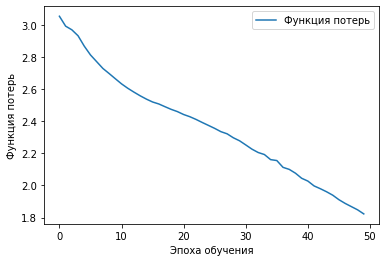

In [18]:
#print(history.history.keys())
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'Функция потерь')
plt.xlabel('Эпоха обучения')
plt.ylabel('Функция потерь')
plt.legend()
plt.show()

Подгружаем в модель веса с наилучшим результатом

In [0]:
filename = "weights-improvement-50-2.0707.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Преобразование обратно в символы

In [0]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

Пробуем делать прогнозы на обученной модели. Сначала начнём с последовательности начальных чисел в качестве входных данных, сгенерируем следующий символ, затем обновим последовательность начальных чисел, чтобы добавить сгенерированный символ в конец, и обрезать первый символ. Этот процесс повторяется до тех пор, пока мы хотим предсказать новые символы (например, последовательность длиной 1000 символов).

Мы можем выбрать случайный шаблон ввода в качестве нашей начальной последовательности, а затем распечатать сгенерированные символы по мере их создания.

In [0]:
import sys
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	#sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
"                                                   w. ben hunt


milwaukee public museum

        pop "

Done.


Аналогичный процесс произведём для двухслойной LSTM, однослойной GRU, и SimpleRNN, полноценные результаты и выводы по экспериментам отражены в прилагающемся отчёте.

In [20]:
# Two layers LSTM Network to Generate Text for "KACHINA DOLLS"
import numpy
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
# load ascii text and covert to lowercase
filename = "Work_text(1).txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history1 = model.fit(X, y, epochs=50, batch_size=64, callbacks=callbacks_list)

Total Characters:  31202
Total Vocab:  67
Total Patterns:  31102
Epoch 1/50
31102/31102 [==============================] - 146s 5ms/step - loss: 3.0214

Epoch 00001: loss improved from inf to 3.02144, saving model to weights-improvement-01-3.0214-bigger.hdf5
Epoch 2/50
31102/31102 [==============================] - 147s 5ms/step - loss: 2.9236

Epoch 00002: loss improved from 3.02144 to 2.92359, saving model to weights-improvement-02-2.9236-bigger.hdf5
Epoch 3/50
31102/31102 [==============================] - 148s 5ms/step - loss: 2.7628

Epoch 00003: loss improved from 2.92359 to 2.76279, saving model to weights-improvement-03-2.7628-bigger.hdf5
Epoch 4/50
31102/31102 [==============================] - 148s 5ms/step - loss: 2.6564

Epoch 00004: loss improved from 2.76279 to 2.65642, saving model to weights-improvement-04-2.6564-bigger.hdf5
Epoch 5/50
31102/31102 [==============================] - 147s 5ms/step - loss: 2.5822

Epoch 00005: loss improved from 2.65642 to 2.58222, saving 

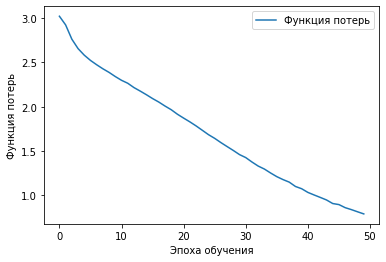

In [21]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'], label = 'Функция потерь')
plt.xlabel('Эпоха обучения')
plt.ylabel('Функция потерь')
plt.legend()
plt.show()

In [0]:
filename = "weights-improvement-50-0.8987-bigger.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
import sys
int_to_char = dict((i, c) for i, c in enumerate(chars))

# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	#sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" n it was
discovered that tourists prized them. and like everything else, someone
saw a chance to ear "

Done.


In [22]:
# One lauer GRU Network to Generate Text "KACHINA DOLLS"
import numpy
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
# load ascii text and covert to lowercase
filename = "Work_text(1).txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the GRU model
model = Sequential()
model.add(GRU(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history2 = model.fit(X, y, nb_epoch=50, batch_size=64, callbacks=callbacks_list)

Total Characters:  31202
Total Vocab:  67
Total Patterns:  31102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/50
31102/31102 [==============================] - 89s 3ms/step - loss: 2.9977

Epoch 00001: loss improved from inf to 2.99774, saving model to weights-improvement-01-2.9977-bigger.hdf5
Epoch 2/50
31102/31102 [==============================] - 89s 3ms/step - loss: 2.8152

Epoch 00002: loss improved from 2.99774 to 2.81519, saving model to weights-improvement-02-2.8152-bigger.hdf5
Epoch 3/50
31102/31102 [==============================] - 88s 3ms/step - loss: 2.7289

Epoch 00003: loss improved from 2.81519 to 2.72893, saving model to weights-improvement-03-2.7289-bigger.hdf5
Epoch 4/50
31102/31102 [==============================] - 88s 3ms/step - loss: 2.6642

Epoch 00004: loss improved from 2.72893 to 2.66421, saving model to weights-improvement-04-2.6642-bigger.hdf5
Epoch 5/50
31102/31102 [==============================] - 88s 3ms/step - loss: 2.6092

Epoch 00005: loss improved from 2.66421 to 2.60916, saving model to weights-improvement-05-2.6092-bigger.hdf5
Epoch 6/50
31102/31

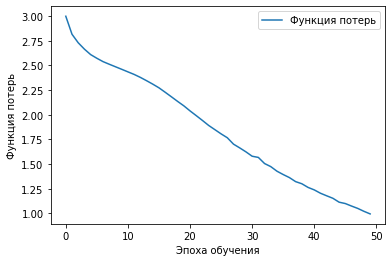

In [23]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label = 'Функция потерь')
plt.xlabel('Эпоха обучения')
plt.ylabel('Функция потерь')
plt.legend()
plt.show()

In [0]:
import sys
int_to_char = dict((i, c) for i, c in enumerate(chars))

# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	#sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" cements dry
quickly, it is better to use a glue that water color will adhere to.
regular hide glue o "

Done.


In [24]:
# One lauer simplleRNN  to Generate Text "KACHINA DOLLS"
import numpy
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
# load ascii text and covert to lowercase
filename = "Work_text(1).txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the SimpleRNN model
model = Sequential()
# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(SimpleRNN(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
history3 = model.fit(X, y, nb_epoch=50, batch_size=64, callbacks=callbacks_list)

Total Characters:  31202
Total Vocab:  67
Total Patterns:  31102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/50
31102/31102 [==============================] - 26s 839us/step - loss: 3.1889

Epoch 00001: loss improved from inf to 3.18895, saving model to weights-improvement-01-3.1889-bigger.hdf5
Epoch 2/50
31102/31102 [==============================] - 26s 826us/step - loss: 3.1819

Epoch 00002: loss improved from 3.18895 to 3.18190, saving model to weights-improvement-02-3.1819-bigger.hdf5
Epoch 3/50
31102/31102 [==============================] - 25s 819us/step - loss: 3.2184

Epoch 00003: loss did not improve from 3.18190
Epoch 4/50
31102/31102 [==============================] - 25s 818us/step - loss: 3.1304

Epoch 00004: loss improved from 3.18190 to 3.13042, saving model to weights-improvement-04-3.1304-bigger.hdf5
Epoch 5/50
31102/31102 [==============================] - 25s 814us/step - loss: 3.0070

Epoch 00005: loss improved from 3.13042 to 3.00705, saving model to weights-improvement-05-3.0070-bigger.hdf5
Epoch 6/50
31102/31102 [==============================] - 25s 816us/step

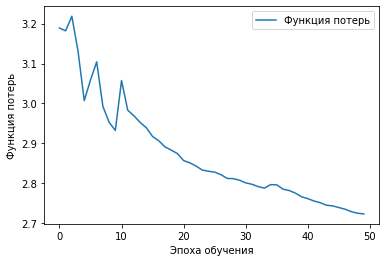

In [25]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label = 'Функция потерь')
plt.xlabel('Эпоха обучения')
plt.ylabel('Функция потерь')
plt.legend()
plt.show()

In [0]:
import sys
int_to_char = dict((i, c) for i, c in enumerate(chars))

# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	#sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" e along these lines. you
will probably get a lot of ideas when traveling, but here are a couple
that "

Done.
